# Laboratorio 2: Clasificación con regresión logística

## Lectura de datos

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image

skin_df = pd.read_csv('data/HAM10000/HAM10000_metadata.csv')

#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('data/HAM10000/', '*', '*.jpg'))}

#Define the path and add as a new column
skin_df['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images.
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((32,32))))

print(skin_df['dx'].value_counts())

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


Para tener una cantidad equitativa de imágenes de cada tipo de lesión, reducimos el dataset de manera aleatoria.

In [43]:
# Establecer una semilla aleatoria para reproducibilidad
np.random.seed(0)

# Número deseado de datapoints por tipo de lesión para las clases especificadas
desired_count = 150

# Filtrar el DataFrame para las clases específicas que deseas reducir
classes_to_reduce = ['nv', 'mel', 'bkl', 'bcc', 'akiec']

# Crear un DataFrame vacío para los nuevos datos reducidos
new_skin_df = pd.DataFrame()

# Iterar a través de las clases y reducir la cantidad de datapoints al azar
for dx_class in classes_to_reduce:
    # Seleccionar aleatoriamente los índices de los datapoints
    selected_indices = np.random.choice(
        skin_df[skin_df['dx'] == dx_class].index, desired_count, replace=False
    )
    
    # Agregar los datapoints seleccionados al nuevo DataFrame
    new_skin_df = pd.concat([new_skin_df, skin_df.loc[selected_indices]])

# Filtrar el DataFrame original para mantener las clases no especificadas
remaining_classes = [dx_class for dx_class in skin_df['dx'].unique() if dx_class not in classes_to_reduce]
remaining_data = skin_df[~skin_df['dx'].isin(classes_to_reduce)]

# Concatenar los DataFrames reducidos y los DataFrames con las clases no especificadas
final_skin_df = pd.concat([new_skin_df, remaining_data])


# Mostrar la cantidad de datos reducidos por clase
#print(final_skin_df['dx'].value_counts())

# Ahora, final_skin_df contiene todas las clases, con algunas clases reducidas a 150 datapoints.
skin_df = final_skin_df
print(skin_df['dx'].value_counts())


dx
nv       150
mel      150
bkl      150
bcc      150
akiec    150
vasc     142
df       115
Name: count, dtype: int64


Listamos las imágenes de cada tipo

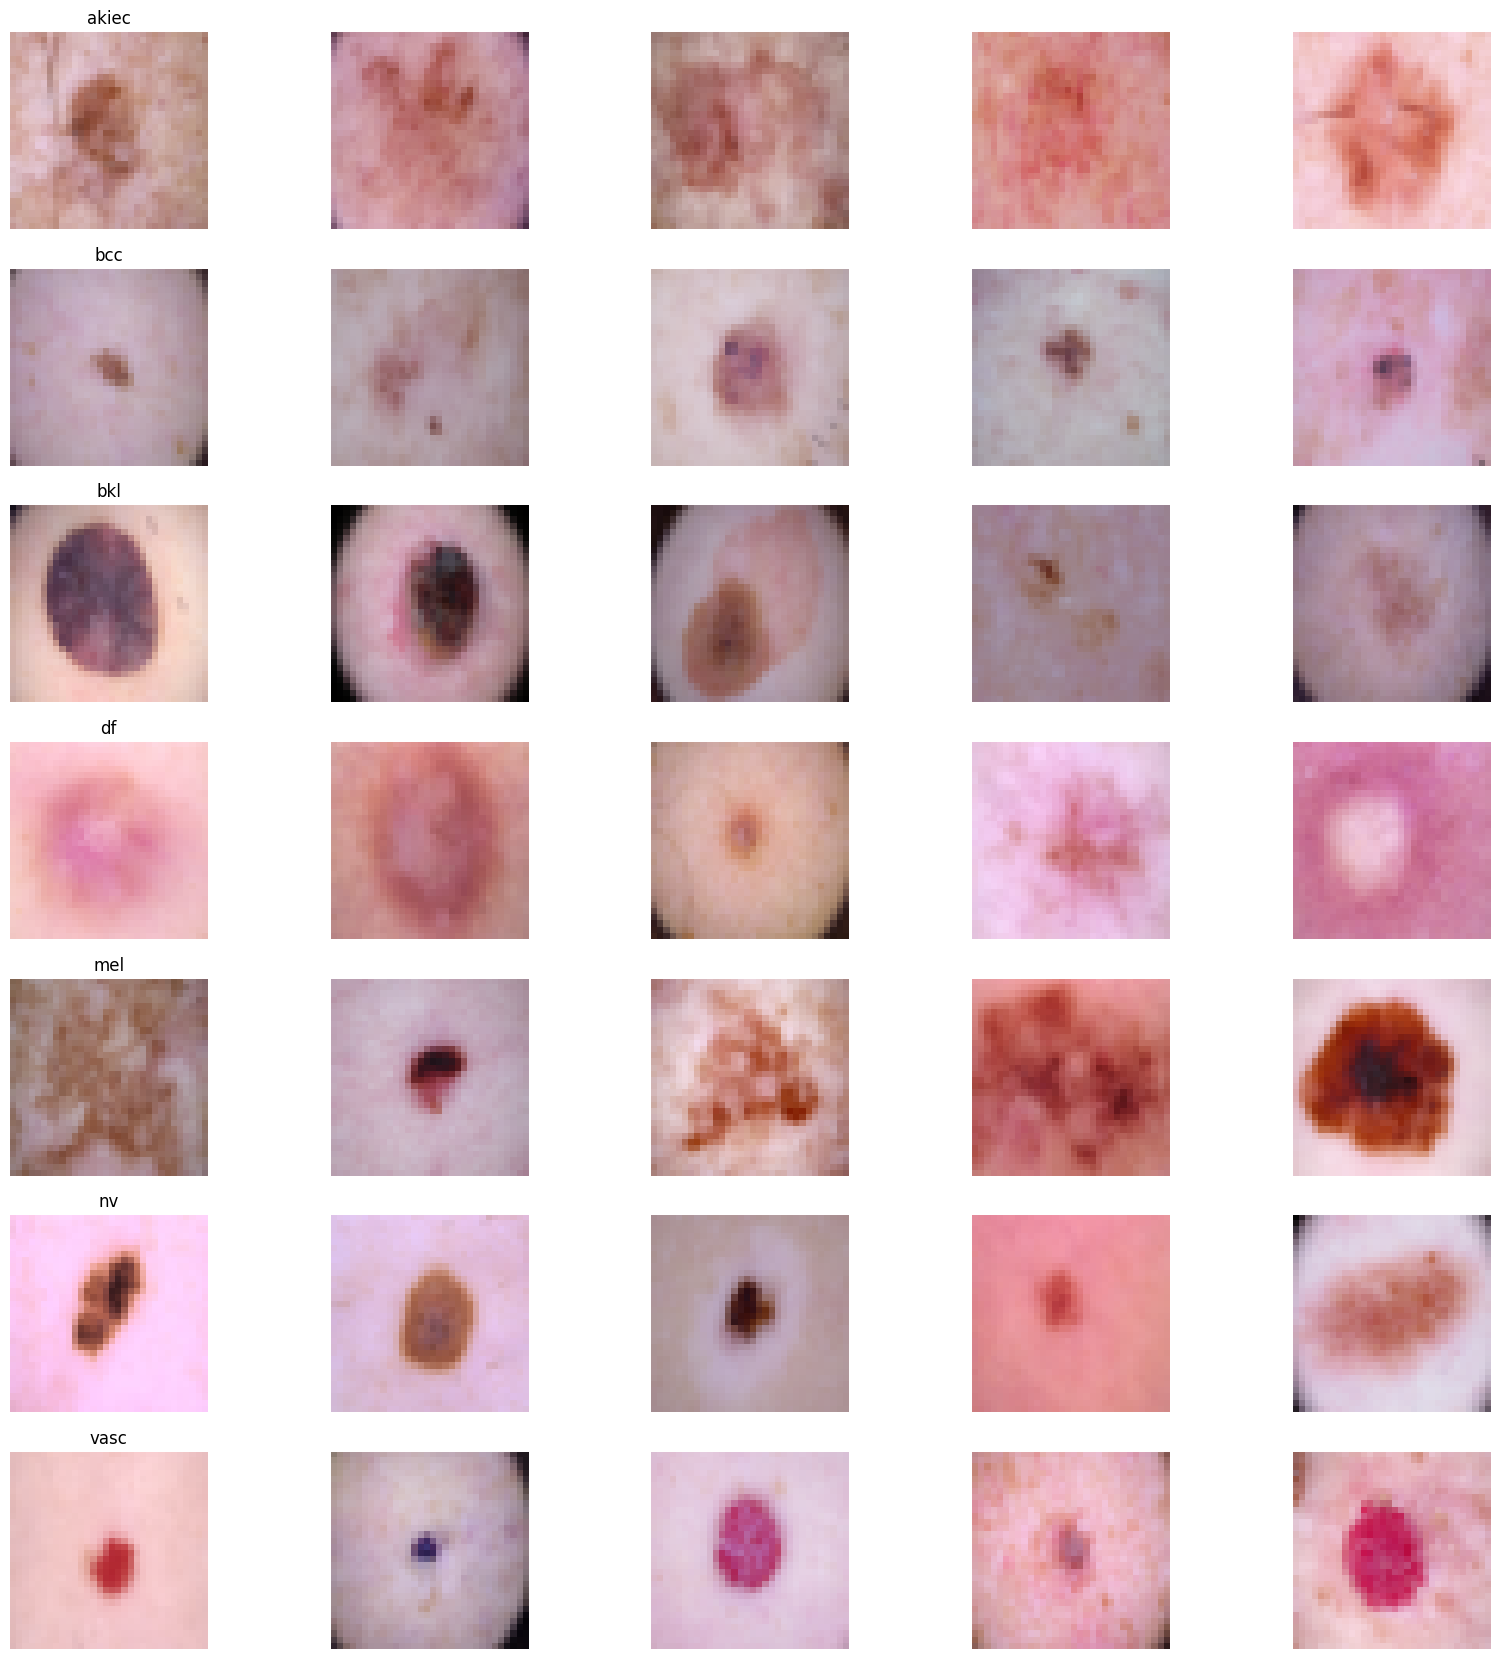

In [44]:
n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

## Clasificación utilizando regresión logística multivariable

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

# Dividir los datos en conjuntos de entrenamiento (60%), validación (25%) y prueba (15%)
X = np.array(skin_df['image'].tolist())  # Características (imágenes)
y = np.array(skin_df['dx'])  # Etiquetas (tipos de lesiones)

# División de entrenamiento (60%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# División de validación y prueba (25% para validation y 15% para test)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.625, random_state=42)

# Crear y entrenar el modelo de regresión logística
logistic_regression_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_regression_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Evaluar el modelo en el conjunto de entrenamiento
y_train_pred = logistic_regression_model.predict(X_train.reshape(X_train.shape[0], -1))

# Evaluar el modelo en el conjunto de validación
y_val_pred = logistic_regression_model.predict(X_val.reshape(X_val.shape[0], -1))

# Evaluar el modelo en el conjunto de prueba
y_test_pred = logistic_regression_model.predict(X_test.reshape(X_test.shape[0], -1))

c:\Users\yared\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Primero, imprimimos la matriz de confusión en los datos de entrenamiento

In [46]:
# Calcular la matriz de confusión en el conjunto de entrenamiento
confusion_train = confusion_matrix(y_train, y_train_pred,labels=skin_df['dx'].unique())

# Imprimir la matriz de confusión en números en bruto
print("Matriz de Confusión (train set):")
for i in skin_df['dx'].unique():
    print(i,end="|")
print()
print(confusion_train)

Matriz de Confusión (train set):
nv|mel|bkl|bcc|akiec|df|vasc|
[[ 85   0   0   0   0   0   0]
 [  0  89   0   0   0   0   0]
 [  0   0  87   0   0   0   0]
 [  0   0   0  78   0   0   0]
 [  0   0   0   0 102   0   0]
 [  0   0   0   0   0  80   0]
 [  0   0   0   0   0   0  83]]


Luego, imprimimos la matriz de confusión en los datos de validación

In [47]:
# Calcular la matriz de confusión en el conjunto de entrenamiento
confusion_val = confusion_matrix(y_val, y_val_pred,labels=skin_df['dx'].unique())

# Imprimir la matriz de confusión en números en bruto
print("Matriz de Confusión (validation set):")
for i in skin_df['dx'].unique():
    print(i,end="|")
print()
print(confusion_val)

Matriz de Confusión (validation set):
nv|mel|bkl|bcc|akiec|df|vasc|
[[14  2  5  0  1  1  1]
 [ 4  6  5  0  3  1  0]
 [ 7  2 10  5  1  3  0]
 [ 0  1  5 10  6  2  5]
 [ 0  1  3  3  8  2  1]
 [ 0  0  1  3  1  7  0]
 [ 1  2  1  4  1  1 11]]


Por último, imprimimos la matriz de confusión en los datos de testeo (test set)

In [48]:
# Calcular la matriz de confusión en el conjunto de prueba
confusion_test = confusion_matrix(y_test, y_test_pred,labels=skin_df['dx'].unique())

# Imprimir la matriz de confusión en números en bruto
print("Matriz de Confusión (test set):")
for i in skin_df['dx'].unique():
    print(i,end="|")
print()
print(confusion_test)

Matriz de Confusión (test set):
nv|mel|bkl|bcc|akiec|df|vasc|
[[20  8  4  2  2  3  2]
 [10 16  2  0  6  8  0]
 [ 4  9 11  1  5  4  1]
 [ 2  4  9 15  8  1  4]
 [ 1  2  3  5 10  9  0]
 [ 1  1  1  3  6  9  2]
 [ 5  2  2  0  3  2 24]]


In [49]:
from sklearn.metrics import accuracy_score

# Calcular el accuracy score en el conjunto de entrenamiento
accuracy_train = accuracy_score(y_train, y_train_pred)
print(f'Accuracy en el conjunto de entrenamiento: {accuracy_train:.2f}')

# Calcular el accuracy score en el conjunto de validación
accuracy_val = accuracy_score(y_val, y_val_pred)
print(f'Accuracy en el conjunto de validación: {accuracy_val:.2f}')

# Calcular el accuracy score en el conjunto de prueba
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f'Accuracy en el conjunto de prueba: {accuracy_test:.2f}')


Accuracy en el conjunto de entrenamiento: 1.00
Accuracy en el conjunto de validación: 0.44
Accuracy en el conjunto de prueba: 0.42


### Aplicando regularización L2

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Dividir los datos en conjuntos de entrenamiento (60%), validación (25%) y prueba (15%)
X = np.array(skin_df['image'].tolist())  # Características (imágenes)
y = np.array(skin_df['dx'])  # Etiquetas (tipos de lesiones)

# División de entrenamiento (60%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# División de validación y prueba (25% para validation y 15% para test)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.625, random_state=42)

# Crear y entrenar el modelo de regresión logística con regularización L2
# Ajusta el valor de C para controlar la fuerza de la regularización (valores más pequeños aumentan la regularización)
logistic_regression_model = LogisticRegression(max_iter=1000, random_state=42, C=0.1, penalty='l2')
logistic_regression_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Evaluar el modelo en el conjunto de entrenamiento
y_train_pred = logistic_regression_model.predict(X_train.reshape(X_train.shape[0], -1))

# Evaluar el modelo en el conjunto de validación
y_val_pred = logistic_regression_model.predict(X_val.reshape(X_val.shape[0], -1))

# Evaluar el modelo en el conjunto de prueba
y_test_pred = logistic_regression_model.predict(X_test.reshape(X_test.shape[0], -1))


c:\Users\yared\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Matriz de confusión (training set):

In [51]:
# Calcular la matriz de confusión en el conjunto de entrenamiento
confusion_train_l2 = confusion_matrix(y_train, y_train_pred,labels=skin_df['dx'].unique())

# Imprimir la matriz de confusión en números en bruto
print("Matriz de Confusión (train set):")
for i in skin_df['dx'].unique():
    print(i,end="|")
print()
print(confusion_train_l2)

Matriz de Confusión (train set):
nv|mel|bkl|bcc|akiec|df|vasc|
[[ 85   0   0   0   0   0   0]
 [  0  89   0   0   0   0   0]
 [  0   0  87   0   0   0   0]
 [  0   0   0  78   0   0   0]
 [  0   0   0   0 102   0   0]
 [  0   0   0   0   0  80   0]
 [  0   0   0   0   0   0  83]]


Matriz de confusión (validation set):

In [52]:
# Calcular la matriz de confusión en el conjunto de entrenamiento
confusion_val_l2 = confusion_matrix(y_val, y_val_pred,labels=skin_df['dx'].unique())

# Imprimir la matriz de confusión en números en bruto
print("Matriz de Confusión (validation set):")
for i in skin_df['dx'].unique():
    print(i,end="|")
print()
print(confusion_val_l2)

Matriz de Confusión (validation set):
nv|mel|bkl|bcc|akiec|df|vasc|
[[14  2  5  0  1  1  1]
 [ 4  5  5  0  3  2  0]
 [ 7  2 10  5  1  3  0]
 [ 0  1  5 10  5  2  6]
 [ 0  1  3  3  7  2  2]
 [ 0  0  1  2  1  8  0]
 [ 1  2  1  4  1  2 10]]


Matriz de confusión (test set):

In [53]:
# Calcular la matriz de confusión en el conjunto de prueba
confusion_test_l2 = confusion_matrix(y_test, y_test_pred,labels=skin_df['dx'].unique())

# Imprimir la matriz de confusión en números en bruto
print("Matriz de Confusión (test set):")
for i in skin_df['dx'].unique():
    print(i,end="|")
print()
print(confusion_test_l2)

Matriz de Confusión (test set):
nv|mel|bkl|bcc|akiec|df|vasc|
[[19  8  5  2  2  3  2]
 [11 16  2  1  6  6  0]
 [ 3 10  9  1  6  5  1]
 [ 2  4  9 16  8  1  3]
 [ 1  2  3  5  9 10  0]
 [ 1  1  1  3  7  8  2]
 [ 5  1  3  1  3  3 22]]


In [54]:
from sklearn.metrics import accuracy_score

# Calcular el accuracy score en el conjunto de entrenamiento
accuracy_train = accuracy_score(y_train, y_train_pred)
print(f'Accuracy en el conjunto de entrenamiento: {accuracy_train:.2f}')

# Calcular el accuracy score en el conjunto de validación
accuracy_val = accuracy_score(y_val, y_val_pred)
print(f'Accuracy en el conjunto de validación: {accuracy_val:.2f}')

# Calcular el accuracy score en el conjunto de prueba
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f'Accuracy en el conjunto de prueba: {accuracy_test:.2f}')


Accuracy en el conjunto de entrenamiento: 1.00
Accuracy en el conjunto de validación: 0.42
Accuracy en el conjunto de prueba: 0.39


### Aplicando regularización L1

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Dividir los datos en conjuntos de entrenamiento (60%), validación (25%) y prueba (15%)
X = np.array(skin_df['image'].tolist())  # Características (imágenes)
y = np.array(skin_df['dx'])  # Etiquetas (tipos de lesiones)

# División de entrenamiento (60%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# División de validación y prueba (25% para validation y 15% para test)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.625, random_state=42)

# Crear y entrenar el modelo de regresión logística con regularización L2
# Ajusta el valor de C para controlar la fuerza de la regularización (valores más pequeños aumentan la regularización)
logistic_regression_model = LogisticRegression(max_iter=1000, random_state=42, C=0.1, penalty='l1', solver='saga')
logistic_regression_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Evaluar el modelo en el conjunto de entrenamiento
y_train_pred = logistic_regression_model.predict(X_train.reshape(X_train.shape[0], -1))

# Evaluar el modelo en el conjunto de validación
y_val_pred = logistic_regression_model.predict(X_val.reshape(X_val.shape[0], -1))

# Evaluar el modelo en el conjunto de prueba
y_test_pred = logistic_regression_model.predict(X_test.reshape(X_test.shape[0], -1))


c:\Users\yared\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Matriz de confusión (training set):

In [56]:
# Calcular la matriz de confusión en el conjunto de entrenamiento
confusion_train_l1 = confusion_matrix(y_train, y_train_pred,labels=skin_df['dx'].unique())

# Imprimir la matriz de confusión en números en bruto
print("Matriz de Confusión (train set):")
for i in skin_df['dx'].unique():
    print(i,end="|")
print()
print(confusion_train_l1)

Matriz de Confusión (train set):
nv|mel|bkl|bcc|akiec|df|vasc|
[[78  0  4  2  1  0  0]
 [ 1 85  1  1  0  1  0]
 [ 2  2 76  4  2  1  0]
 [ 0  0  2 70  5  0  1]
 [ 0  0  0  2 99  1  0]
 [ 2  1  3  3  1 69  1]
 [ 0  0  2  3  0  0 78]]


Matriz de confusión (validation set):

In [57]:
# Calcular la matriz de confusión en el conjunto de entrenamiento
confusion_val_l1 = confusion_matrix(y_val, y_val_pred,labels=skin_df['dx'].unique())

# Imprimir la matriz de confusión en números en bruto
print("Matriz de Confusión (validation set):")
for i in skin_df['dx'].unique():
    print(i,end="|")
print()
print(confusion_val_l1)

Matriz de Confusión (validation set):
nv|mel|bkl|bcc|akiec|df|vasc|
[[16  2  2  0  2  1  1]
 [ 3 11  1  0  3  1  0]
 [ 7  2  9  5  3  2  0]
 [ 0  0  3 17  4  2  3]
 [ 0  3  1  1 10  1  2]
 [ 1  0  1  3  1  5  1]
 [ 1  2  1  2  1  3 11]]


Matriz de confusión (test set):

In [58]:
# Calcular la matriz de confusión en el conjunto de prueba
confusion_test_l1 = confusion_matrix(y_test, y_test_pred,labels=skin_df['dx'].unique())

# Imprimir la matriz de confusión en números en bruto
print("Matriz de Confusión (test set):")
for i in skin_df['dx'].unique():
    print(i,end="|")
print()
print(confusion_test_l1)

Matriz de Confusión (test set):
nv|mel|bkl|bcc|akiec|df|vasc|
[[21  7  5  1  1  2  4]
 [ 7 17  3  1  3  9  2]
 [ 3 12  9  1  6  3  1]
 [ 0  3 13 14  5  5  3]
 [ 1  3  2  5 12  7  0]
 [ 1  1  1  4  7  8  1]
 [ 5  2  2  0  3  1 25]]


In [59]:
from sklearn.metrics import accuracy_score

# Calcular el accuracy score en el conjunto de entrenamiento
accuracy_train = accuracy_score(y_train, y_train_pred)
print(f'Accuracy en el conjunto de entrenamiento: {accuracy_train:.2f}')

# Calcular el accuracy score en el conjunto de validación
accuracy_val = accuracy_score(y_val, y_val_pred)
print(f'Accuracy en el conjunto de validación: {accuracy_val:.2f}')

# Calcular el accuracy score en el conjunto de prueba
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f'Accuracy en el conjunto de prueba: {accuracy_test:.2f}')

Accuracy en el conjunto de entrenamiento: 0.92
Accuracy en el conjunto de validación: 0.52
Accuracy en el conjunto de prueba: 0.42
